# Prepare you environment on your host computer

<span style="color: red;">Note：This part of code run on your host computer</span>

The Jupyter Notebook right up have a button like ![select kernel](../pictures/Chapter5/select_kernel.png), then you choose ```Select Another Kernel```, and choose ```Python Environments```, then choose ```Creat Python Environment``` and choose ```Venv```, then choose ```python3.10```.

In [ ]:
# Here is my hostcomputer information
# Linux PC 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64 x86_64 GNU/Linux

!uname -a

In [ ]:
# Here is my python version
# Python 3.10.12

!python -V

In [ ]:
# Install torch and torchvision
%pip install torch torchvision pycocotools opencv-python

# Step 2:Prepare your dateset

I want to build a model to detect different fruit include banana, apple and orange. So I need to collect some pictures of this fruit. And I use [robflow](https://roboflow.com/) to label my dataset.

## Step 1: Create Project

Select ```New Project```:

<img src="../pictures/Chapter5/roboflow_1.png" width="600" height="400">

Fill your project information and create the project

<img src="../pictures/Chapter5/roboflow_2.png" width="600" height="400">

## Step 2: Update images and annotate

Update images

<img src="../pictures/Chapter5/roboflow_3.png" width="600" height="400">

Label your image

<img src="../pictures/Chapter5/roboflow_4.png" width="600" height="400">

## Step 3: Export dataset

Add annotated image to your dataset

<img src="../pictures/Chapter5/roboflow_5.png" width="600" height="400">

Generate New version of your dataset

<img src="../pictures/Chapter5/roboflow_6.png" width="600" height="400">

Download your dataset

<img src="../pictures/Chapter5/roboflow_7.png" width="600" height="400">


In [ ]:
# Download your dataset, and you can also train your model on roboflow   
!curl -L "https://app.roboflow.com/ds/cvnhUR23e7?key=0FnycWm689" > roboflow.zip  && unzip ./roboflow.zip && rm ./roboflow.zip

# Step 3: Training Faster R-cnn

In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO


# Define CustomCocoDataset for your dataset
class CustomCocoDataset(torchvision.datasets.CocoDetection):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)


In [2]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

def get_model(num_classes):
    # Load a pre-trained model for classification and return it
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from pycocotools.cocoeval import COCOeval
import numpy as np

# Choose the best device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the transforms
transform = T.Compose([
    T.ToTensor(),
    # T.Resize((512, 512))
])

# Create the dataset and DataLoader
train_dataset = CustomCocoDataset("train", "train/_annotations.coco.json", transforms=transform)
valid_dataset = CustomCocoDataset("valid", "valid/_annotations.coco.json", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model and optimizer
num_classes = 4  # Including background class
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
for image, targets in train_dataset:
    print(targets)

{'boxes': tensor([[ 24.0000, 375.0000, 216.0000, 505.5000],
        [257.0000, 344.0000, 364.0000, 487.5000],
        [385.0000, 337.0000, 494.5000, 501.5000]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([0]), 'area': tensor([25056.0000, 15354.5000, 18012.7500]), 'iscrowd': tensor([0, 0, 0])}
{'boxes': tensor([[ 22.0000, 372.0000, 218.5000, 512.0000],
        [253.0000, 344.0000, 362.5000, 490.0000],
        [381.0000, 335.0000, 495.0000, 499.5000]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([1]), 'area': tensor([27510., 15987., 18753.]), 'iscrowd': tensor([0, 0, 0])}
{'boxes': tensor([[ 78.0000, 488.0000, 254.5000, 640.0000],
        [241.0000, 405.0000, 368.0000, 620.5000],
        [399.0000, 442.0000, 541.5000, 618.5000]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([2]), 'area': tensor([26828.0000, 27368.5000, 25151.2500]), 'iscrowd': tensor([0, 0, 0])}
{'boxes': tensor([[ 25.0000, 432.0000, 172.0000, 618.0000],
        [175.0000, 482.0000, 411.5000, 619.5000],
  

In [15]:
# Function to convert PyTorch outputs to COCO-style annotations
def convert_to_coco_format(outputs, targets):
    coco_results = []
    for output, target in zip(outputs, targets):
        image_id = target["image_id"].item()
        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()
        
        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box
            coco_result = {
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                "score": float(score)
            }
            coco_results.append(coco_result)
    return coco_results

# Function to evaluate mAP using COCOeval
def evaluate_map(model, data_loader, coco_gt):
    model.eval()
    coco_predictions = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            # Convert model outputs to COCO format
            coco_predictions.extend(convert_to_coco_format(outputs, targets))
    
    # Load the ground truth COCO annotations
    coco_dt = coco_gt.loadRes(coco_predictions)
    
    # Perform COCO evaluation
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# Load the COCO ground truth annotations for validation
coco_gt = COCO("valid/_annotations.coco.json")

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Iteration [{i}], Loss: {losses.item()}")

    # End of epoch: print average loss
    print(f"Epoch [{epoch}/{num_epochs}] finished with average loss: {running_loss / len(train_loader)}")

    # Evaluate on validation set using mAP
    print(f"Evaluating mAP on validation set after epoch {epoch}")
    evaluate_map(model, valid_loader, coco_gt)

print("Training complete!")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch [0/20], Iteration [0], Loss: 1.686745285987854
Epoch [0/20], Iteration [10], Loss: 0.3548065721988678
Epoch [0/20] finished with average loss: 0.4449145182967186
Evaluating mAP on validation set after epoch 0
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average 

In [16]:
test_dataset = CustomCocoDataset("test", "test/_annotations.coco.json", transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

coco_gt = COCO("test/_annotations.coco.json")
evaluate_map(model, test_loader, coco_gt)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

boxes [[182.4677   486.48615  409.89413  621.2133  ]
 [ 30.824463 428.92     173.40344  615.6261  ]
 [407.6647   412.01767  531.7351   603.6683  ]]
score [0.99989986 0.9998847  0.99982613]


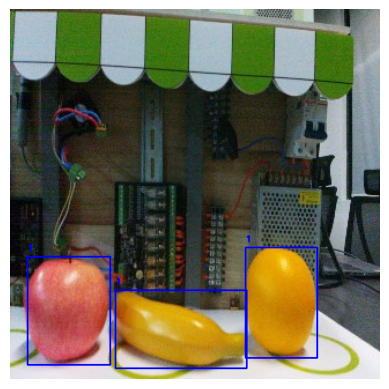

In [18]:
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 加载预训练的 Faster R-CNN 模型
model.eval()  # 设置为评估模式

# 定义图像预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为 tensor
])

# 加载并处理输入图像
img_path = './test/20240918111056023_jpg.rf.27341363336ab55424a222714f5c26b2.jpg'  # 替换为你的图片路径
image = Image.open(img_path).convert("RGB")  # 使用 Pillow 加载图像
img_tensor = transform(image).unsqueeze(0)  # 增加 batch 维度

# 使用模型进行推理
with torch.no_grad():  # 不计算梯度
    predictions = model(img_tensor)

# 获取预测结果
boxes = predictions[0]['boxes'].numpy()  # 边界框坐标
print(f"boxes {boxes}")
scores = predictions[0]['scores'].numpy()
print(f"score {scores}")# 置信度
labels = predictions[0]['labels'].numpy()  # 类别标签

# 设置阈值，只保留高置信度的检测结果
threshold = 0.5
filtered_boxes = boxes[scores > threshold]
filtered_labels = labels[scores > threshold]

# 在原始图像上绘制边界框
cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)  # 转换为 BGR 格式
for box, label in zip(filtered_boxes, filtered_labels):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(cv_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 绘制矩形框
    cv2.putText(cv_image, str(label.item()), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# 展示结果图像
plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 不显示坐标轴
plt.show()


# Step 4: Export to ONNX format

In [19]:
from torch.onnx import export

dummy_input = torch.randn(1,3,512, 512, requires_grad=True)  

torch.onnx.export(
    model,                              
    dummy_input,
    "faster_rcnn.onnx",                 
    input_names=["input"],              
    output_names=["output"],            
    opset_version=11,                   
    do_constant_folding=True,          
    dynamic_axes={                      
        "input": {0: "batch_size"},     
        "output": {0: "batch_size"}
    }
)

/home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/.venv/lib/python3.10/site-packages/torch/nn/functional.py:4031: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/.venv/lib/python3.10/site-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/jiahao/Tutorial-of-AI-Kit-with-Raspberry-Pi-From-Zero-to-Hero/.venv/lib/python3.10/site-packages/torchvision/ops/boxes.py:168: UserWarning